In [1]:
%matplotlib inline

# Input Datasets  

In [2]:
import pandas
data_folder = '../data'
date_format='%Y-%M-%d' #truncate datetimes to dates
invoices = pandas.read_csv(data_folder + '/invoice.csv', na_values='inf', 
                           parse_dates=['invoice_date', 'due_date', 'cleared_date'], date_format=date_format)
payments = pandas.read_csv(data_folder + '/invoice_payments.csv', na_values='inf',
                           parse_dates=['transaction_date'], date_format=date_format)

## Dataset Definitions & Relationships

We have two input datasets: invoices and their payments.
- Payments are amounts in time, which are directly mapped to companies. 
- Invoices can have multiple payments, but usually only have 1. 

In [3]:
invoices.dtypes

id                                   int64
due_date                    datetime64[ns]
invoice_date                datetime64[ns]
status                              object
amount_inv                         float64
currency                            object
company_id                           int64
customer_id                          int64
account_id                           int64
cleared_date                datetime64[ns]
root_exchange_rate_value           float64
dtype: object

In [4]:
payments.dtypes

amount                             float64
root_exchange_rate_value           float64
transaction_date            datetime64[ns]
invoice_id                           int64
company_id                           int64
converted_amount                   float64
dtype: object

In [5]:
#The join key will be invoice_id, so it must be unique (and it is).
invoices.id.value_counts(dropna=False).value_counts(dropna=False)\
.to_frame(name="ids").rename_axis('invoices_per_id')

,ids
invoices_per_id,
1,113085


In [6]:
payments.invoice_id.value_counts(dropna=False).value_counts(dropna=False)\
.to_frame(name="invoices").rename_axis('payments_per_invoice')

,invoices
payments_per_invoice,
1,98920
2,5751
3,268
4,59
5,15
6,8
14,1
9,1
8,1


### Transforming Dates to Quantities

In [46]:
invoice_time_allowed = invoices.due_date - invoices.invoice_date
invoice_time_open = invoices.cleared_date - invoices.invoice_date
invoice_time_late = invoice_time_open - invoice_time_allowed

In [64]:
invoices['days_allowed'] = invoice_time_allowed.map(lambda t: t.days if not pandas.isnull(t) else None)
invoices['days_open'] = invoice_time_open.map(lambda t: t.days if not pandas.isnull(t) else None)
invoices['days_late'] = invoice_time_late.map(lambda t: t.days if not pandas.isnull(t) else None)

invoices['months_allowed'] = (invoices.due_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M'))
invoices.months_allowed = invoices.months_allowed.map(lambda m: m.n if not pandas.isnull(m) else None)
invoices['months_open'] = (invoices.cleared_date.dt.to_period('M') - invoices.invoice_date.dt.to_period('M'))
invoices.months_open = invoices.months_open.map(lambda m: m.n if not pandas.isnull(m) else None)
invoices['months_late'] = (invoices.cleared_date.dt.to_period('M') - invoices.due_date.dt.to_period('M'))
invoices.months_late = invoices.months_late.map(lambda m: m.n if not pandas.isnull(m) else None)

## Entity Definitions & Relationships

- Company: business entity for which Tesorio is forecasting cash collected. There are only two. Each company collects using multiple currencies from multiple customers. 
- Account: **In this limited dataset, accounts and companies are synonymous, so we ignore accounts.**  
- Customer: metadata about an invoice which is specific to each company. 

In [165]:
invoices.groupby("company_id")[["customer_id","currency"]].nunique()

,customer_id,currency
company_id,,
14,546,13
114,4509,15


In [10]:
invoices.groupby("customer_id").company_id.nunique().value_counts()\
.to_frame(name='customers').rename_axis('companies_per_customer')

,customers
companies_per_customer,
1,5055


In [11]:
invoices.groupby("company_id").account_id.nunique().to_frame(name="unique_accounts")

,unique_accounts
company_id,
14,1
114,1


In [12]:
invoices.groupby("account_id").company_id.nunique().value_counts()\
.to_frame(name='count').rename_axis('companies_per_account')

,count
companies_per_account,
1,2


## Data Cleaning Needs

### Payments

Transaction data begins in 2011 and ends on 2021-01-31. 

In [13]:
payments.__len__()

111623

In [69]:
payment_stats = payments.describe(include='all')
payment_stats.loc['% populated'] = payment_stats.loc['count']/payments.__len__()
payment_stats

,amount,root_exchange_rate_value,transaction_date,invoice_id,company_id,converted_amount
count,111622.000000,111623.000000,111623,111623.000000,111623.000000,1.116220e+05
mean,9416.980646,0.968372,2017-09-21 16:48:01.513129216,56528.677575,110.865341,9.128716e+03
min,0.000004,0.000806,2011-01-01 00:05:00,0.000000,14.000000,1.800562e-08
25%,4078.626249,1.000000,2016-01-18 00:07:00,28303.000000,114.000000,3.180972e+03
50%,9332.665539,1.000000,2018-01-20 00:02:00,56476.000000,114.000000,8.819620e+03
75%,14651.495863,1.000000,2020-01-05 00:02:00,84775.500000,114.000000,1.461286e+04
max,19999.879159,3.253307,2021-01-31 00:03:00,113084.000000,114.000000,6.120943e+04
std,6015.336178,0.244600,NaN,32634.233788,17.425341,6.438813e+03
% populated,0.999991,1.000000,1.0,1.000000,1.000000,9.999910e-01


In [15]:
#converted_amount is reliable
(((payments.amount * payments.root_exchange_rate_value) - payments.converted_amount).abs()).max()

1.0913936421275139e-11

array([[<Axes: title={'center': 'amount'}>,
        <Axes: title={'center': 'root_exchange_rate_value'}>,
        <Axes: title={'center': 'converted_amount'}>]], dtype=object)

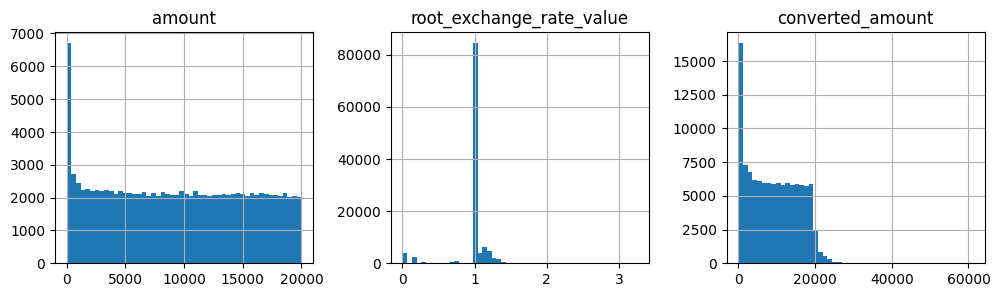

In [16]:
payments.select_dtypes(include='float').hist(bins=50, figsize=(12, 3), layout=(1,3))

### Invoices

In [77]:
invoices_stats = invoices.describe(include='all')
invoices_stats.loc['% populated'] = invoices_stats.loc['count']/invoices.__len__()
invoices_stats

,id,due_date,invoice_date,status,amount_inv,currency,company_id,customer_id,account_id,cleared_date,root_exchange_rate_value,days_allowed,days_open,days_late,months_open,months_allowed,months_late
count,113085.000000,113060,113085,113085,113085.000000,113085,113085.000000,113085.000000,113085.000000,113085,113085.000000,113060.000000,113085.000000,113060.000000,113085.000000,113060.000000,113060.000000
unique,NaN,NaN,NaN,2,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,CLEARED,NaN,USD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,109382,NaN,85146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,56542.000000,2017-10-18 01:21:46.726340096,2017-09-09 19:59:16.684971776,NaN,10026.599910,NaN,111.135783,751.424778,0.028642,2017-11-18 00:39:17.928637952,0.970822,38.019591,69.009975,30.890324,2.338241,1.275358,1.062869
min,0.000000,2010-01-07 00:09:00,2010-01-21 00:12:00,NaN,0.027581,NaN,14.000000,0.000000,0.000000,2011-01-01 00:05:00,0.000815,-2931.000000,-753.000000,-1085.000000,-24.000000,-96.000000,-36.000000
25%,28271.000000,2016-01-20 00:05:00,2016-01-18 00:08:00,NaN,5030.122601,NaN,114.000000,129.000000,0.000000,2016-01-21 00:08:00,1.000000,-1.000000,-5.000000,-6.000000,0.000000,0.000000,0.000000
50%,56542.000000,2018-01-22 00:04:00,2018-01-20 00:05:00,NaN,10018.092660,NaN,114.000000,411.000000,0.000000,2018-01-24 00:04:00,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,84813.000000,2020-01-11 00:07:00,2020-01-08 00:12:00,NaN,15029.685611,NaN,114.000000,995.000000,0.000000,2020-01-10 00:05:00,1.000000,1.000000,15.000000,8.000000,0.000000,0.000000,0.000000
max,113084.000000,2023-01-31 00:01:00,2023-01-01 00:01:00,NaN,19999.974875,NaN,114.000000,5054.000000,1.000000,2022-01-01 00:01:00,1.681560,731.000000,1110.000000,2922.000000,36.000000,24.000000,96.000000


In [83]:
#opened outside of payment data time period
(invoices.loc[invoices.invoice_date>payments.transaction_date.max()].__len__(), 
invoices.loc[invoices.invoice_date<payments.transaction_date.min()].__len__())

(15, 1)

### Cleared vs Open 

- Open invoices still have a date cleared

In [84]:
invoices.status.value_counts(normalize=True, dropna=False).to_frame(name="% of Invoices")

,% of Invoices
status,
CLEARED,0.967255
OPEN,0.032745


In [85]:
invoices.loc[invoices.status == 'OPEN'].cleared_date.value_counts(dropna=False)

cleared_date
2022-01-01 00:01:00    3703
Name: count, dtype: int64

In [86]:
invoices.loc[invoices.cleared_date.isnull() != (invoices.status == 'OPEN'),['status','cleared_date']]\
.value_counts(dropna=False)

status  cleared_date       
OPEN    2022-01-01 00:01:00    3703
Name: count, dtype: int64

### Date Relationships for Cleared Invoices

In [87]:
cleared_invoices = invoices.query("status=='CLEARED'").drop(columns=['status'])

<Axes: title={'center': 'Cleared Invoices: Days Open'}, ylabel='Frequency'>

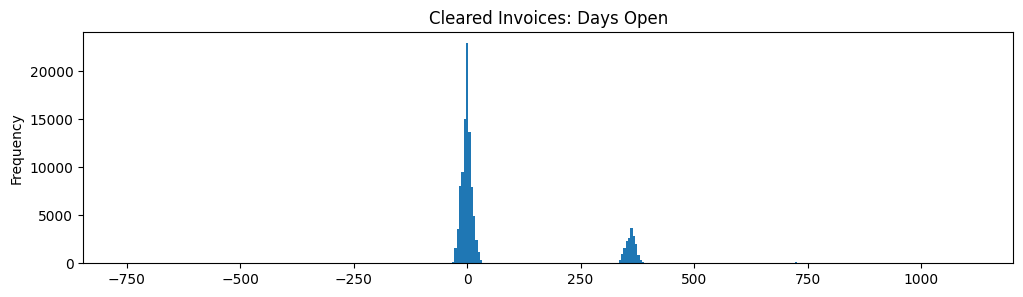

In [89]:
#invoices are either cleared around the normal billing cycle or a year later
cleared_invoices.days_open.plot(kind='hist',bins=365, title="Cleared Invoices: Days Open", figsize=(12, 3))

In [97]:
cleared_invoices.__len__()/invoices.__len__()

0.9672547199009595

In [135]:
#invoices are either open only in the month they became active or a year later
cleared_invoices.months_open.value_counts(normalize=True, dropna=False)

months_open
 0     0.833227
 12    0.163180
 24    0.002112
-12    0.001124
 36    0.000265
-24    0.000091
Name: proportion, dtype: float64

In [104]:
#invoices are either due the same month they became active or a year later
cleared_invoices.months_allowed.value_counts(normalize=True, dropna=False)

months_allowed
 0.0     0.890101
 12.0    0.109579
 NaN     0.000229
-12.0    0.000055
 24.0    0.000018
-48.0    0.000009
-96.0    0.000009
Name: proportion, dtype: float64

In [102]:
cleared_invoices.months_late.value_counts(normalize=True, dropna=False)

months_late
 0.0     0.922986
 12.0    0.064243
-12.0    0.010587
 24.0    0.001582
 36.0    0.000238
 NaN     0.000229
-24.0    0.000110
 48.0    0.000009
-36.0    0.000009
 96.0    0.000009
Name: proportion, dtype: float64

In [134]:
cleared_invoices['months_late_vs_allowed'] = cleared_invoices.months_late/(cleared_invoices.months_allowed+1)
cleared_invoices.months_late_vs_allowed.value_counts(normalize=True, dropna=False)

months_late_vs_allowed
 0.000000     0.922986
 12.000000    0.063639
-0.923077     0.009481
 24.000000    0.001545
-12.000000    0.001097
 0.923077     0.000558
 36.000000    0.000238
 NaN          0.000229
-24.000000    0.000082
-1.090909     0.000046
 1.846154     0.000027
-1.846154     0.000027
-0.480000     0.000009
-1.021277     0.000009
-2.769231     0.000009
-2.181818     0.000009
-1.010526     0.000009
Name: proportion, dtype: float64

array([[<Axes: title={'center': 'amount_inv'}>,
        <Axes: title={'center': 'root_exchange_rate_value'}>,
        <Axes: title={'center': 'days_allowed'}>],
       [<Axes: title={'center': 'days_late'}>,
        <Axes: title={'center': 'months_allowed'}>,
        <Axes: title={'center': 'months_late'}>],
       [<Axes: title={'center': 'months_open_vs_allowed'}>,
        <Axes: title={'center': 'months_late_vs_allowed'}>, <Axes: >]],
      dtype=object)

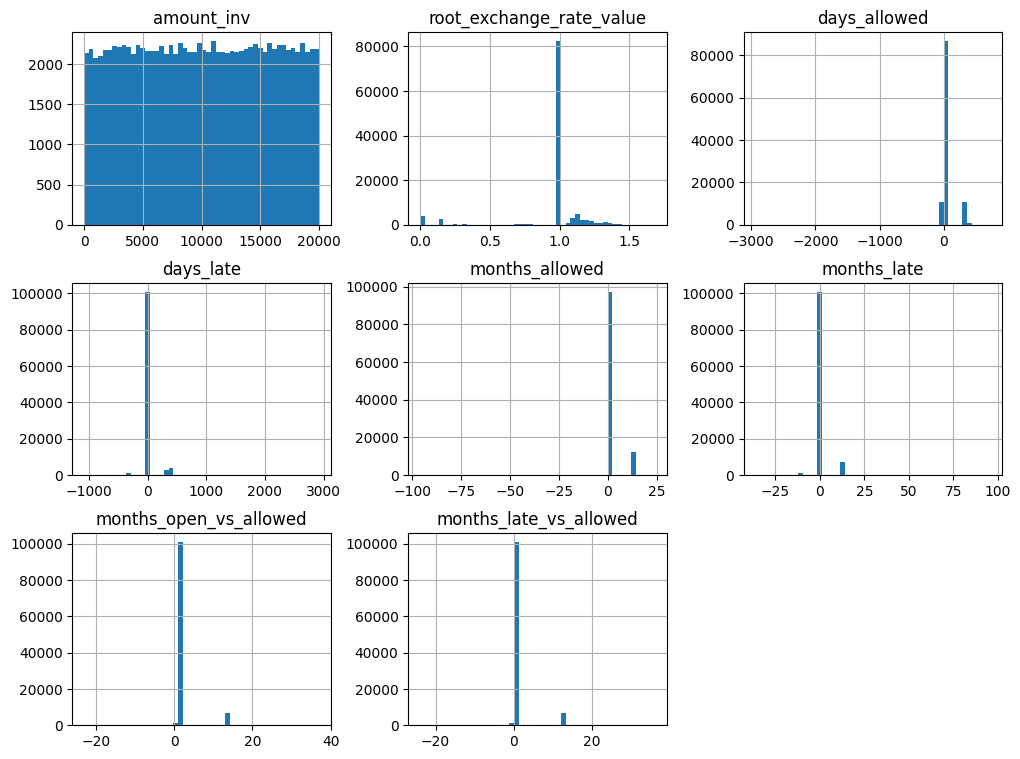

In [137]:
cleared_invoices.select_dtypes(include=['float']).hist(bins=50, figsize=(12, 9))

### Exchange Rate

Exchange rates change for both payments and open invoices. Customers would expect to pay the amount they were originally invoiced in their own currency, not the USD amount originally invoiced. Therefore, we should use raw amounts to determine how much is paid vs due. 

<Axes: title={'center': 'Exchange Rate Spread Ratio'}, xlabel='currency'>

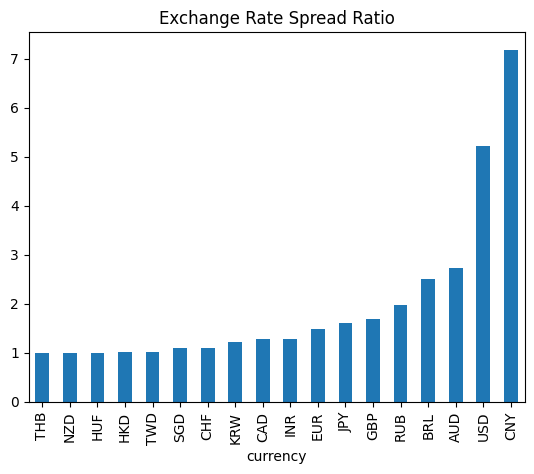

In [157]:
# USD is not is always 1 - it varies a lot
currency_ranges = cleared_invoices.groupby("currency").root_exchange_rate_value.describe(percentiles=[])
(currency_ranges['max']/currency_ranges['min']).sort_values().plot(kind='bar', title="Exchange Rate Spread Ratio")

In [146]:
# a significant % of cleared USD invoices have an exchange rate unequal to 1
cleared_invoices_usd = cleared_invoices\
.query("currency=='USD' and months_allowed>=0 and months_allowed<=12 and months_late<=12").copy()
cleared_invoices_usd['exchange_rate_is_1'] = cleared_invoices_usd['root_exchange_rate_value'] == 1
cleared_invoices_usd.exchange_rate_is_1.mean()

0.9845438613572194

In [162]:
# USD exchange rate variations from 1 tend to be invoices which took longer to clear
# This suggests that the invoice exchange rate is "current state data." 
time_to_clear = cleared_invoices_usd.cleared_date - cleared_invoices_usd.invoice_date
cleared_invoices_usd['months_to_clear'] = time_to_clear.map(lambda t: round(t.days/30))
cleared_invoices_usd.months_to_clear.value_counts(normalize=True, dropna=False)

months_to_clear
 0     0.712358
 12    0.127020
-1     0.083877
 1     0.051030
 13    0.012219
 11    0.011732
-12    0.001010
-13    0.000365
 24    0.000170
 25    0.000073
-24    0.000061
-11    0.000037
-25    0.000037
 23    0.000012
Name: proportion, dtype: float64

In [160]:
cleared_invoices_usd.groupby("exchange_rate_is_1").months_to_clear.agg(['mean','count'])

,mean,count
exchange_rate_is_1,,
False,2.855118,1270
True,1.748745,80898


<Axes: title={'center': '% of USD Invoices With Exchange Rate Equal to 1'}, xlabel='months_to_clear'>

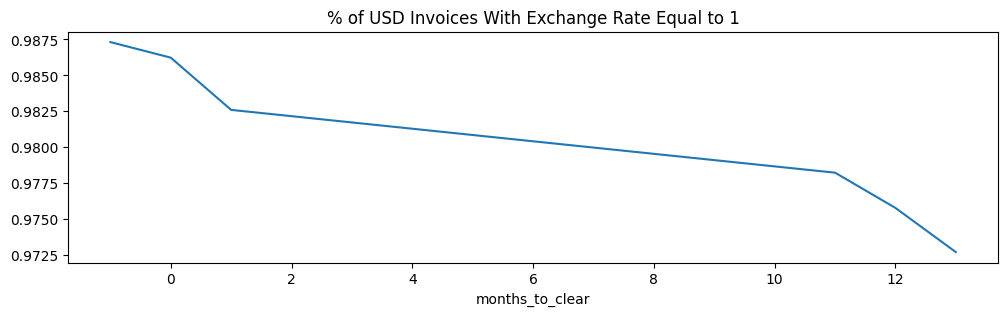

In [163]:
cleared_invoices_usd.groupby(cleared_invoices_usd.months_to_clear.clip(upper=13, lower=-1))\
.exchange_rate_is_1.mean().plot(title='% of USD Invoices With Exchange Rate Equal to 1', figsize=(12,3))

### Merge

- 18% of payments are partial. 
- Exchange rates vary across payments.
- Companies are consistent between payments and invoices, when payments are present

In [168]:
#all payment invoices are represented in both datasets 
len(set(payments.invoice_id) - set(invoices.id))

0

In [169]:
#7% of invoices do not have payments yet
len(set(invoices.id) - set(payments.invoice_id))/invoices.__len__()

0.07127382057744175

In [170]:
invoice_payments = invoices.rename(columns={"id":"invoice_id","amount_inv":"amount"})\
.merge(payments, on="invoice_id", how='left', suffixes=('_inv', '_pmt'))

In [171]:
duplicated_columns = [col.replace('_pmt','') for col in invoice_payments.columns if col.endswith('_pmt')]
for col in  duplicated_columns:
    inconsistent_rows = invoice_payments.loc[invoice_payments[col + '_pmt']!=invoice_payments[col + '_inv']]
    print(f"{col}: {inconsistent_rows.__len__()/invoice_payments.__len__()} inconsistent rows in merged dataset")

amount: 0.1829583148818128 inconsistent rows in merged dataset
root_exchange_rate_value: 0.30690240050800865 inconsistent rows in merged dataset
company_id: 0.06734456856863548 inconsistent rows in merged dataset


In [175]:
invoice_payments.query("company_id_pmt!=company_id_inv").company_id_pmt.value_counts()

Series([], Name: count, dtype: int64)

## Adding Analytical Variables 

### Date Quantity Variables

#### Broken Down By Period

What period-level should we use? (day, week, month)
Create periods from invoice date to close date
Rolling payment window: due_date - current period
Rolling days open: cleared_date - current period 

# Metadata Calculations & Cleaning

Totals, Uniques, Averages, Ranges, Outliers, Missings
Variables: Invoices, USD Amounts, Cleared/Open, Due Date, Invoice Date, Transaction Date, Customers, Companies, Accounts

# Notes

## Notable entities

e.g. customers with notable values

## Sparsity

### Entities

### Date Periods

## Trends Over Time

# Analysis

## Business Motivation

Cash collections don't follow due dates

## Data Science Benchmark

Define & Quantify: customers' mean absolute % error each period from cash due.

## Data Science Target

Best outcome variable? 
Days late
Days open (Total and Rolling)
Days Open as a % of Payment Window (Total and Rolling)
Days Late as a % of Payment Window (Total and Rolling)